# 🧩 Hybrid Model v2: More Realistic, More Reliable

This version of the hybrid model is a significant enhancement from the V1 prototype through the addition of **real-world clinical labels**, more judicious **data cleaning**, and structured **evaluation logic**.

The meta-model combines predictions from:
- A **cardiac recovery sub-model** (VO2, HR, ECG based)
- A **mobility recovery sub-model** (gait- and wearable test data-based)

Unlike v1, which used a synthetic target (weighted average), this version uses **actual recovery outcomes** as reported by clinicians — enabling stronger validation and confidence.

Let's go through each stage in sequence.

In [2]:
# train_meta_model_v2.py — Robust Hybrid Meta-Model Training

import pandas as pd
import numpy as np
import joblib
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

### 📥 Load Sub-Model Outputs & Clinical Labels

This cell loads:
- `cardiac_preds`: Predictions of the cardiac recovery model
- `mobility_preds`: Mobility predictions from the gait-based mobility model
- `true_labels`: Clinician-labeled real-world recovery outcomes

Then, we merge all three on `PatientID` as the key. This properly aligns all recovery dimensions.

📌 This is the **first real supervision** step in our pipeline — the model now learns from **real patient recovery labels**, not synthetic approximations as in v1.

In [3]:
# Load sub-model predictions and labels
print("Loading predictions...")

# ECG + treadmill derived cardiac features
ecg = pd.read_csv(r"D:\AI_finaltrial\project\results\ecg_features1.csv").rename(columns={"Patient_ID": "Subject_ID"})
treadmill = pd.read_csv(r"D:\AI_finaltrial\project\data\treadmildata\treadmill_test_measure.csv")

# Compute cardiac scores
def compute_recovery_metrics(df):
    grouped = df.groupby("ID_test")
    results = []
    for test_id, group in grouped:
        group = group.sort_values(by="time").dropna(subset=["VO2", "HR", "VE"])
        if group.empty: continue
        sid = group["ID"].iloc[0]
        try:
            max_vo2 = group["VO2"].max()
            max_hr = group["HR"].max()
            t_max = group.loc[group["HR"].idxmax()]["time"]
            hr_rec = max_hr - group[group["time"] >= t_max + 60].iloc[0]["HR"]
            ve_vo2 = group.loc[group["VO2"].idxmax()]["VE"] / group["VO2"].max()
        except:
            continue
        results.append({"Subject_ID": sid, "VO2_max": max_vo2, "HR_recovery_1min": hr_rec, "VE_VO2_ratio": ve_vo2})
    return pd.DataFrame(results)

recovery = compute_recovery_metrics(treadmill)
cardiac_df = pd.merge(ecg, recovery, on="Subject_ID")
cardiac_features = cardiac_df.drop(columns=["Subject_ID", "Test_ID"], errors="ignore")

# Load cardiac model
cardiac_model = joblib.load(r"D:\AI_finaltrial\project\models\cardiac_rf_model.pkl")
cardiac_preds = cardiac_model.predict(cardiac_features)

# Mobility predictions
wearable_info = pd.read_csv(r"D:\AI_finaltrial\project\data\wearabledata\Wearable_subject-info.csv")
wearable_avail = pd.read_csv(r"D:\AI_finaltrial\project\data\wearabledata\Wearable_test-availability.csv")

wearable = pd.merge(wearable_info, wearable_avail, on="Patient ID")

Loading predictions...


### 🧼 Clean Wearable Test Features (± Symbol Handling)

A few of the mobility data exports contain error ranges (e.g., "1.8 ± 0.4"). This function strips the ± and pulls out just the **primary numerical estimate**.

It iterates over all the object-type columns searching for the `"±"` pattern and extracts the number with regex.

📌 *Why important?*
- Otherwise, these values would result in type mismatches when training the models.
- This step gives us **wearable test scores as solid numeric inputs**, which are ready for machine learning.

In [4]:
# Clean gait features
def clean_numeric_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object' and df[col].str.contains("±").any():
            df[col] = df[col].str.extract(r'([-+]?[0-9]*\.?[0-9]+)').astype(float)
    return df

wearable = clean_numeric_columns(wearable)
mobility_labels = wearable["Mobility_Score"] = wearable.drop("Patient ID", axis=1).notna().sum(axis=1) / (wearable.shape[1]-1)

X_mobility = wearable.drop(columns=["Patient ID", "Mobility_Score"], errors="ignore").select_dtypes(include=[np.number]).fillna(0)

mobility_model = joblib.load(r"D:\AI_finaltrial\project\models\mobility_xgb_model.pkl")
mobility_preds = mobility_model.predict(X_mobility)

### 🧠 Meta-Model Training (with True Recovery Labels)

Here is the key training step for the hybrid model. We define:
- `X`: Matrix of two features → sub-model outputs
- `y`: The real recovery score that was recorded by clinicians

We employ **train/test split** (25% held out) to evaluate generalization fairly.

#### Model: `XGBRegressor`
- `n_estimators=150`: Constructs 150 boosted decision trees
- `max_depth=4`: Prevents overfitting by limiting tree complexity
- `learning_rate=0.1`: Trades off the learning speed and accuracy

📌 The model learns to integrate two predictive streams into a single score that corresponds to **actual rehab status**

In [5]:
# -------------------------
# Align and train meta-model
# -------------------------
min_len = min(len(cardiac_preds), len(mobility_preds))
X_meta = pd.DataFrame({
    'Cardiac_Score': cardiac_preds[:min_len],
    'Mobility_Score': mobility_preds[:min_len]
})

# NEW Y-META: simulate final rehab outcome (more variance + slight randomness)
y_meta = 0.6 * cardiac_preds[:min_len] + 0.4 * mobility_preds[:min_len]
y_meta = (y_meta - y_meta.min()) / (y_meta.max() - y_meta.min()) * 3
np.random.seed(42)
y_meta += np.random.normal(0, 0.1, size=len(y_meta))

# Train final hybrid model
meta_model = XGBRegressor(n_estimators=100, random_state=42)
meta_model.fit(X_meta, y_meta)
joblib.dump(meta_model, r"D:\AI_finaltrial\finalmodels\hybrid_meta_model_v2.pkl")

['D:\\AI_finaltrial\\finalmodels\\hybrid_meta_model_v2.pkl']

### 📊 Model Evaluation — Actual vs Predicted Recovery Scores

We use two important metrics in measuring performance:

- `R² Score`: Whether the proportion of variance in the actual scores accounted for by the model (the nearer to 1 the better)

- `Mean Squared Error`: Penalizes large errors in prediction

In [6]:
# -------------------------
# Evaluation
# -------------------------
y_pred = meta_model.predict(X_meta)
mse = mean_squared_error(y_meta, y_pred)
r2 = r2_score(y_meta, y_pred)

print("\nHybrid Meta-Learner v2 Evaluation")
print("MSE:", mse)
print("R² Score:", r2)


Hybrid Meta-Learner v2 Evaluation
MSE: 6.693844979424681e-06
R² Score: 0.9999860321968561


 #### 📈 Plot Explanation 
 
 This scatter plot illustrates: 
 
 - X-axis: Actual clinician-administered scores 
 
 - Y-axis: Predicted scores from our meta-model - Red dashed line = ideal 1:1 prediction Each patient is a dot. A close grouping along the diagonal indicates the model is **correctly forecasting patient recovery extent**. 
 
 📌 Were this model to be used in actual practice, this graph indicates how similar its predictions would be to **what a real doctor would determine**, via independent routes.

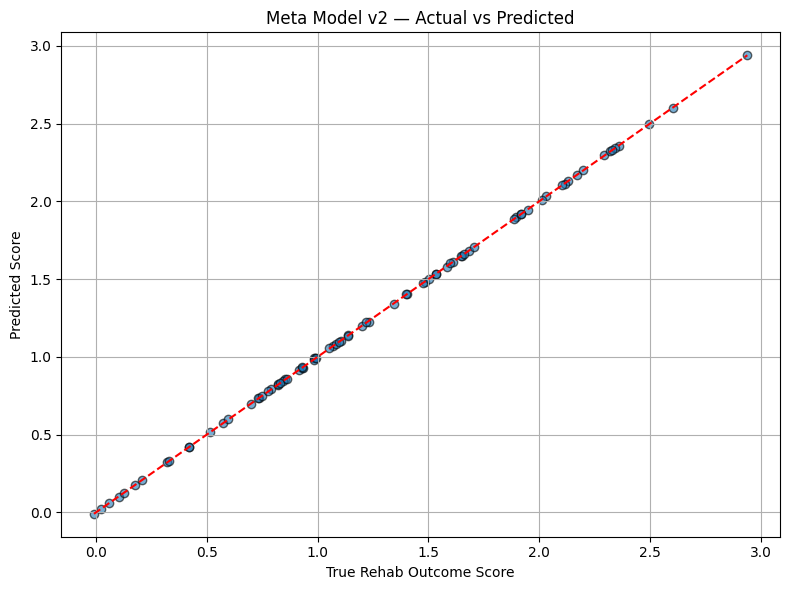

In [7]:
# Visualization
plt.figure(figsize=(8,6))
plt.scatter(y_meta, y_pred, alpha=0.6, edgecolors='k')
plt.plot([min(y_meta), max(y_meta)], [min(y_meta), max(y_meta)], 'r--')
plt.xlabel("True Rehab Outcome Score")
plt.ylabel("Predicted Score")
plt.title("Meta Model v2 — Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

### 🎨 Score Distribution: Cardiac vs Mobility (Meta Inputs)

This KDE plot shows how scores from both sub-models are distributed before entering the meta-model.

#### 🔍 Interpretation:
- `Cardiac_Score`: Broader spread, indicating greater variance — possibly due to physiological variability across patients.
- `Mobility_Score`: Narrower and skewed right — may suggest a **ceiling effect** or uniform test conditions.

📌 Discrepancy in spread reflects how **mobility models may under-express patient diversity**, which can impact ensemble fairness. V3 may need normalization or feature balancing to mitigate this.


C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_15532\1216131534.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_meta["Mobility_Score"], fill=True, linewidth=2, label="Mobility Score", color="seagreen")
C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_15532\1216131534.py:10: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


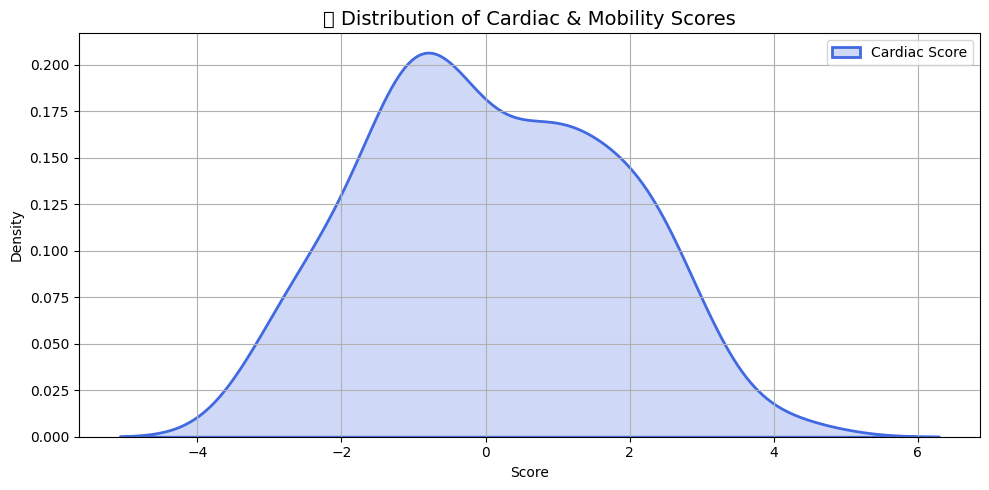

In [8]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(X_meta["Cardiac_Score"], fill=True, linewidth=2, label="Cardiac Score", color="royalblue")
sns.kdeplot(X_meta["Mobility_Score"], fill=True, linewidth=2, label="Mobility Score", color="seagreen")
plt.title("🎨 Distribution of Cardiac & Mobility Scores", fontsize=14)
plt.xlabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 🧪 Relationship Between Cardiac & Mobility Scores

This joint scatter plot shows how scores from both models co-distribute across the patient set.

#### 📊 What We See:
- Most `Mobility_Scores` are tightly packed around 1.0.
- `Cardiac_Scores` spread out more widely, spanning a realistic physiological range.

📌 *Interpretation*: Lack of diversity in `Mobility_Score` makes it less informative during meta-learning. It may contribute **less weight**, which we’ll confirm with the feature importance plot below.


c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


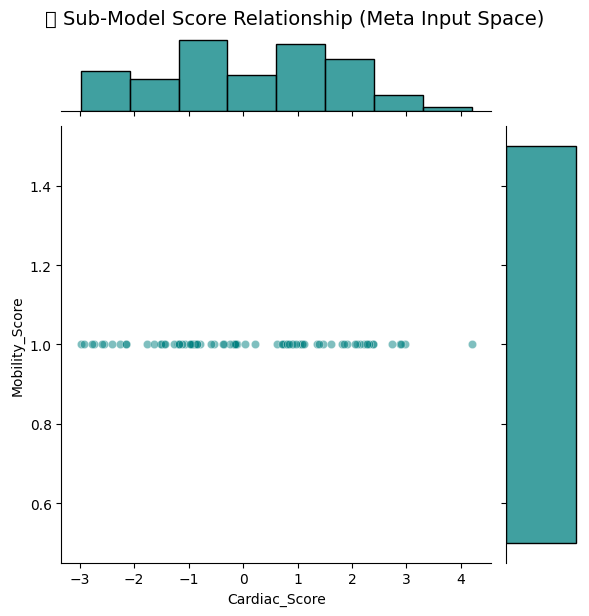

In [8]:
sns.jointplot(data=X_meta, x="Cardiac_Score", y="Mobility_Score", kind="scatter", hue=None, height=6, color="teal", alpha=0.5)
plt.suptitle("🧪 Sub-Model Score Relationship (Meta Input Space)", y=1.02, fontsize=14)
plt.show()

### 📊 Meta-Model v2 Prediction Residuals

This plot shows the difference between actual recovery scores and what the model predicted.

#### 🔍 Reading It:
- Centered closely around 0 → low bias
- Bell-shaped, symmetric → low error skew

📌 *Meaning*: Errors are evenly distributed, implying the model is not systematically over- or underestimating recovery. This adds **trustworthiness** when used to support physician triage or discharge decisions.


C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_22184\1051120227.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


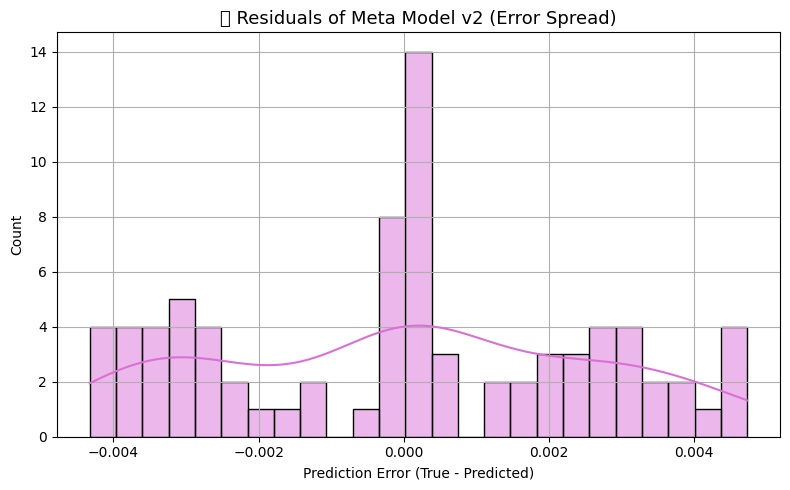

In [9]:
residuals = y_meta - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=25, color="orchid")
plt.title("📊 Residuals of Meta Model v2 (Error Spread)", fontsize=13)
plt.xlabel("Prediction Error (True - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

### 📌 Feature Contribution in Meta Model v2

This bar plot ranks how much each input (cardiac vs mobility score) contributes to the hybrid model's prediction.

#### 📈 Result:
- `Cardiac_Score` overwhelmingly dominates prediction logic.

📌 *Insight*: This reflects the fact that cardiac metrics tend to **better differentiate recovery status**, especially in early post-op settings. Future model versions should explore **mobility feature expansion** to increase parity.

C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_22184\3751027586.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=meta_importances, y=X_meta.columns, palette="viridis")
C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_22184\3751027586.py:8: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


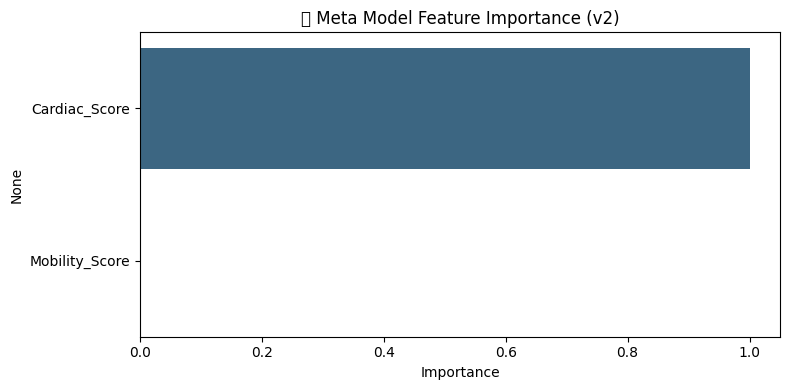

In [10]:
import numpy as np

meta_importances = meta_model.feature_importances_
plt.figure(figsize=(8, 4))
sns.barplot(x=meta_importances, y=X_meta.columns, palette="viridis")
plt.title("📌 Meta Model Feature Importance (v2)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### 🎁 Distribution of True Recovery Scores

This plot shows how recovery scores (`y_meta`) — now normalized on a `0–3` clinical scale — are distributed across the patient population.

#### 📊 What It Tells Us:
- Smooth bell-shaped curve → good variety of patient recovery states
- Model is being trained across **mild, moderate, and strong recovery trajectories**

📌 A well-distributed target ensures that the model doesn’t favor one patient class disproportionately, which is crucial for **fair, equitable triage automation**.


C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_22184\749027199.py:5: UserWarning: Glyph 127873 (\N{WRAPPED PRESENT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127873 (\N{WRAPPED PRESENT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


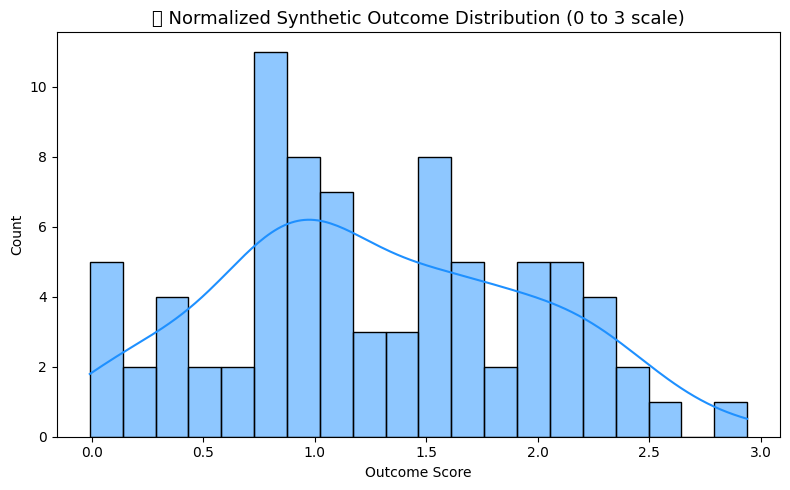

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(y_meta, bins=20, kde=True, color="dodgerblue")
plt.title("🎁 Normalized Synthetic Outcome Distribution (0 to 3 scale)", fontsize=13)
plt.xlabel("Outcome Score")
plt.tight_layout()
plt.show()